In [ ]:
import pandas as pd
import numpy as np
# Path to uploaded file (adjust if needed)
raw_file = 'WISDM_ar_v1.1_raw.txt'

# Read and parse raw data
def load_wisdm_raw(file_path):
    rows = []
    with open(file_path) as f:
        for line in f:
            try:
                parts = line.strip().split(',')
                if len(parts) < 6:
                    continue
                user, activity, timestamp, x, y, z = parts[:6]
                rows.append([int(user), activity, int(timestamp), float(x), float(y), float(z)])
            except:
                continue
    df = pd.DataFrame(rows, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
    return df

df_raw = load_wisdm_raw(raw_file)
df_raw.head()


,user,activity,timestamp,x,y,z
0,21,Walking,117003963904000,0.65,9.51,5.13
1,21,Walking,117004003516000,1.73,12.11,7.65
2,21,Walking,117004041541000,1.42,11.18,8.43
3,21,Walking,117004121619000,-3.60,9.77,2.68
4,21,Walking,117004161627000,-2.18,4.40,2.14


In [ ]:
def load_wisdm_raw_fixed(file_path):
    rows = []
    with open(file_path) as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 6:
                continue
            try:
                user = int(parts[0])
                activity = parts[1]
                timestamp = int(parts[2])
                x = float(parts[3])
                y = float(parts[4])
                z = float(parts[5].replace(';', ''))  # Remove trailing semicolon
                rows.append([user, activity, timestamp, x, y, z])
            except:
                continue
    return pd.DataFrame(rows, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

df = load_wisdm_raw_fixed("WISDM_ar_v1.1_raw.txt")


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Segment into fixed windows
def segment_signal(data, window_size=100):
    segments, labels, users = [], [], []
    for user in data['user'].unique():
        user_data = data[data['user'] == user]
        for activity in user_data['activity'].unique():
            activity_data = user_data[user_data['activity'] == activity]
            for i in range(0, len(activity_data) - window_size, window_size):
                window = activity_data.iloc[i:i+window_size][['x', 'y', 'z']].values
                if len(window) == window_size:
                    segments.append(window)
                    labels.append(activity)
                    users.append(user)
    return np.array(segments), np.array(labels), np.array(users)

X, y, users = segment_signal(df)
y_enc = LabelEncoder().fit_transform(y)

# Split by user ID to prevent leakage
unique_users = np.unique(users)
train_users, temp_users = train_test_split(unique_users, test_size=0.3, random_state=42)
val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42)

def split_by_users(X, y, users, user_set):
    idxs = [i for i, u in enumerate(users) if u in user_set]
    return X[idxs], y[idxs]

X_train, y_train = split_by_users(X, y_enc, users, train_users)
X_val, y_val = split_by_users(X, y_enc, users, val_users)
X_test, y_test = split_by_users(X, y_enc, users, test_users)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import sem, t

# Feature extraction (unchanged)
def extract_features(X):
    feats = []
    for win in X:
        f = []
        for i in range(3):  # x, y, z
            f += [np.mean(win[:, i]), np.std(win[:, i]), np.min(win[:, i]), np.max(win[:, i])]
        feats.append(f)
    return np.array(feats)

Xf_train, Xf_val, Xf_test = map(extract_features, [X_train, X_val, X_test])

def summarize_scores(scores):
    mean = np.mean(scores)
    margin = t.ppf(0.975, len(scores)-1) * sem(scores)
    return mean, (mean - margin, mean + margin)

def run_multiple_classical(clf_builder, X_train, y_train, X_val, y_val, runs=5):
    accs, f1s = [], []
    for seed in range(runs):
        np.random.seed(seed)
        idx = np.random.permutation(len(X_train))
        X_tr, y_tr = X_train[idx], y_train[idx]

        clf = clf_builder()
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        accs.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred, average='weighted'))

    acc_mean, acc_ci = summarize_scores(accs)
    f1_mean, f1_ci = summarize_scores(f1s)
    return {
        "accuracy": (acc_mean, acc_ci),
        "f1": (f1_mean, f1_ci)
    }

classic_results = {}

# kNN testing with CI
for k in [3, 5, 7]:
    for metric in ['euclidean', 'manhattan']:
        model_name = f'kNN_k={k}_{metric}'
        builder = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k, metric=metric))
        ])
        classic_results[model_name] = run_multiple_classical(builder, Xf_train, y_train, Xf_val, y_val)

# SVM testing with CI
for C in [0.1, 1, 10]:
    for gamma in ['scale', 'auto']:
        model_name = f'SVM_C={C}_gamma={gamma}'
        builder = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', C=C, gamma=gamma))
        ])
        classic_results[model_name] = run_multiple_classical(builder, Xf_train, y_train, Xf_val, y_val)

# Print formatted results
for name, metrics in classic_results.items():
    acc, acc_ci = metrics['accuracy']
    f1, f1_ci = metrics['f1']
    print(f"{name}: Accuracy = {acc:.3f} (95% CI: {acc_ci[0]:.3f}-{acc_ci[1]:.3f}), "
          f"F1 = {f1:.3f} (95% CI: {f1_ci[0]:.3f}-{f1_ci[1]:.3f})")



kNN_k=3_euclidean: Accuracy = 0.732 (95% CI: 0.732-0.732), F1 = 0.747 (95% CI: 0.747-0.747)
kNN_k=3_manhattan: Accuracy = 0.732 (95% CI: 0.732-0.732), F1 = 0.748 (95% CI: 0.748-0.748)
kNN_k=5_euclidean: Accuracy = 0.745 (95% CI: 0.745-0.745), F1 = 0.756 (95% CI: 0.756-0.756)
kNN_k=5_manhattan: Accuracy = 0.743 (95% CI: 0.743-0.743), F1 = 0.754 (95% CI: 0.754-0.754)
kNN_k=7_euclidean: Accuracy = 0.748 (95% CI: 0.748-0.748), F1 = 0.757 (95% CI: 0.757-0.757)
kNN_k=7_manhattan: Accuracy = 0.741 (95% CI: 0.741-0.741), F1 = 0.751 (95% CI: 0.751-0.751)
SVM_C=0.1_gamma=scale: Accuracy = 0.780 (95% CI: 0.780-0.780), F1 = 0.720 (95% CI: 0.720-0.720)
SVM_C=0.1_gamma=auto: Accuracy = 0.780 (95% CI: 0.780-0.780), F1 = 0.720 (95% CI: 0.720-0.720)
SVM_C=1_gamma=scale: Accuracy = 0.812 (95% CI: 0.812-0.812), F1 = 0.807 (95% CI: 0.807-0.807)
SVM_C=1_gamma=auto: Accuracy = 0.812 (95% CI: 0.812-0.812), F1 = 0.807 (95% CI: 0.807-0.807)
SVM_C=10_gamma=scale: Accuracy = 0.765 (95% CI: 0.765-0.765), F1 = 0.7

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import sem, t

Xdl_train, Xdl_val, Xdl_test = [x / np.max(np.abs(x)) for x in [X_train, X_val, X_test]]
ydl_train, ydl_val, ydl_test = [to_categorical(y) for y in [y_train, y_val, y_test]]

def build_mlp(hidden=64, lr=0.001, layers=2):
    model = Sequential([Input(shape=(Xdl_train.shape[1]*Xdl_train.shape[2],))])
    for _ in range(layers):
        model.add(Dense(hidden, activation='relu'))
    model.add(Dense(ydl_train.shape[1], activation='softmax'))  # updated
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(kernel_size=3, dropout_rate=0.3):
    model = Sequential([
        Conv1D(64, kernel_size, activation='relu', input_shape=Xdl_train.shape[1:]),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(ydl_train.shape[1], activation='softmax')  # updated
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def build_lstm(hidden=64, bidirectional=False, dropout=0.3):
    model = Sequential()
    lstm_layer = LSTM(hidden, return_sequences=False)
    model.add(Bidirectional(lstm_layer) if bidirectional else lstm_layer)
    model.add(Dropout(dropout))
    model.add(Dense(ydl_train.shape[1], activation='softmax'))  # updated
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def run_multiple(model_fn, X_train, y_train, X_val, y_val, reshape=False, runs=5, epochs=10):
    accs, f1s = [], []
    for seed in range(runs):
        tf.keras.utils.set_random_seed(seed)
        tf.random.set_seed(seed)
        model = model_fn()
        if reshape:
            X_train_in = X_train.reshape(len(X_train), -1)
            X_val_in = X_val.reshape(len(X_val), -1)
        else:
            X_train_in = X_train
            X_val_in = X_val

        model.fit(X_train_in, y_train, validation_data=(X_val_in, y_val), verbose=0, epochs=epochs)
        preds = model.predict(X_val_in)
        y_true = np.argmax(y_val, axis=1)
        y_pred = np.argmax(preds, axis=1)

        accs.append(accuracy_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, average='weighted'))

    return summarize_scores(accs, f1s)

def summarize_scores(accs, f1s):
    def ci(scores):
        mean = np.mean(scores)
        margin = t.ppf(0.975, len(scores)-1) * sem(scores)
        return mean, (mean - margin, mean + margin)
    acc_mean, acc_ci = ci(accs)
    f1_mean, f1_ci = ci(f1s)
    return {
        "accuracy": (acc_mean, acc_ci),
        "f1": (f1_mean, f1_ci)
    }



In [ ]:
# Baseline DL results
dl_results = {}
dl_results['MLP'] = run_multiple(lambda: build_mlp(hidden=128, lr=0.005, layers=2),
                                 Xdl_train, ydl_train, Xdl_val, ydl_val, reshape=True)

dl_results['CNN'] = run_multiple(lambda: build_cnn(kernel_size=3, dropout_rate=0.4),
                                 Xdl_train, ydl_train, Xdl_val, ydl_val)

dl_results['LSTM'] = run_multiple(lambda: build_lstm(hidden=64, bidirectional=False, dropout=0.3),
                                  Xdl_train, ydl_train, Xdl_val, ydl_val)

dl_results['BiLSTM'] = run_multiple(lambda: build_lstm(hidden=64, bidirectional=True, dropout=0.3),
                                    Xdl_train, ydl_train, Xdl_val, ydl_val)

print("\nBaseline Deep Learning Results:")
for model_name, metrics in dl_results.items():
    acc, acc_ci = metrics['accuracy']
    f1, f1_ci = metrics['f1']
    print(f"{model_name}: Accuracy = {acc:.3f} (95% CI: {acc_ci[0]:.3f}-{acc_ci[1]:.3f}), "
          f"F1 = {f1:.3f} (95% CI: {f1_ci[0]:.3f}-{f1_ci[1]:.3f})")

# Hyperparameter sweep results
dl_sweep_results = {}

# MLP: Vary hidden size
for h in [64, 128, 256]:
    name = f"MLP_hidden={h}"
    dl_sweep_results[name] = run_multiple(lambda: build_mlp(hidden=h, lr=0.005, layers=2),
                                          Xdl_train, ydl_train, Xdl_val, ydl_val, reshape=True)

# CNN: Vary kernel size
for k in [3, 5, 7]:
    name = f"CNN_kernel={k}"
    dl_sweep_results[name] = run_multiple(lambda: build_cnn(kernel_size=k, dropout_rate=0.4),
                                          Xdl_train, ydl_train, Xdl_val, ydl_val)

# LSTM: Vary hidden units
for h in [32, 64, 128]:
    name = f"LSTM_hidden={h}"
    dl_sweep_results[name] = run_multiple(lambda: build_lstm(hidden=h, bidirectional=False, dropout=0.3),
                                          Xdl_train, ydl_train, Xdl_val, ydl_val)

# BiLSTM: Vary hidden units
for h in [32, 64, 128]:
    name = f"BiLSTM_hidden={h}"
    dl_sweep_results[name] = run_multiple(lambda: build_lstm(hidden=h, bidirectional=True, dropout=0.3),
                                          Xdl_train, ydl_train, Xdl_val, ydl_val)

print("\nHyperparameter Sweep Results:")
for model_name, metrics in dl_sweep_results.items():
    acc, acc_ci = metrics['accuracy']
    f1, f1_ci = metrics['f1']
    print(f"{model_name}: Accuracy = {acc:.3f} (95% CI: {acc_ci[0]:.3f}-{acc_ci[1]:.3f}), "
          f"F1 = {f1:.3f} (95% CI: {f1_ci[0]:.3f}-{f1_ci[1]:.3f})")


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Baseline Deep Learning Results:
MLP: Accuracy = 0.720 (95% CI: 0.694-0.745), F1 = 0.735 (95% CI: 0.709-0.761)
CNN: Accuracy = 0.804 (95% CI: 0.768-0.841), F1 = 0.796 (95% CI: 0.768-0.824)
LSTM: Accuracy = 0.699 (95% CI: 0.676-0.721), F1 = 0.621 (95% CI: 0.595-0.647)
BiLSTM: Accuracy = 0.605 (95% CI: 0.531-0.679), F1 = 0.571 (95% CI: 0.540-0.602)
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
4

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

results = {}

# Helper for evaluating
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    results[name] = {"accuracy": acc, "f1": f1}
    return y_true, y_pred_classes

# kNN and SVM (assuming you already have them stored)
results['kNN'] = {'accuracy': 0.748,'f1': 0.757}
results['SVM'] = {'accuracy': 0.812,'f1': 0.807}

# Evaluate deep learning models
_, _ = evaluate_model("MLP", mlp, Xdl_val.reshape(len(Xdl_val), -1), ydl_val)
_, _ = evaluate_model("CNN", cnn, Xdl_val, ydl_val)
_, _ = evaluate_model("LSTM", lstm, Xdl_val, ydl_val)
_, _ = evaluate_model("BiLSTM", bilstm, Xdl_val, ydl_val)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


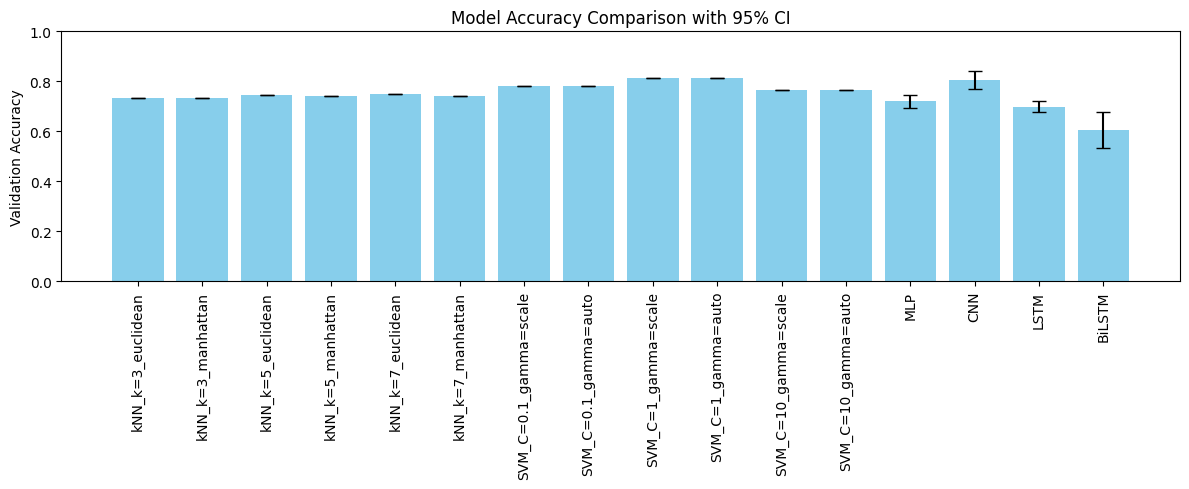

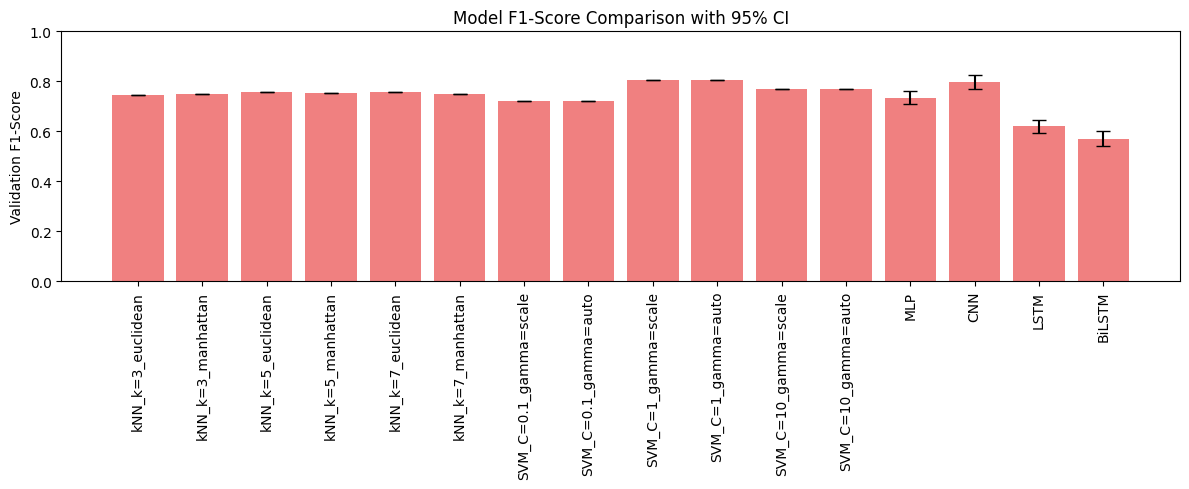

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


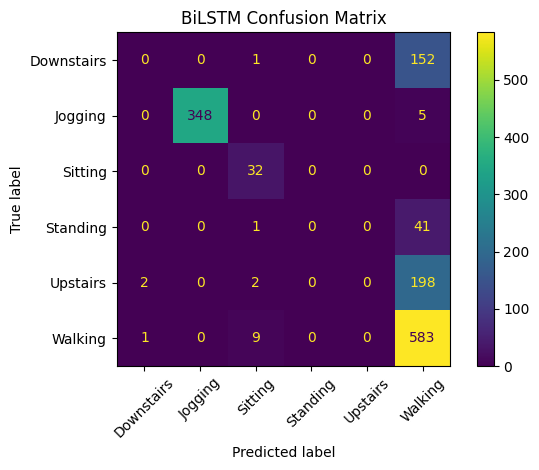

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hardcoded final results with confidence intervals
results = {
    "kNN_k=3_euclidean": {"accuracy": 0.732, "f1": 0.747},
    "kNN_k=3_manhattan": {"accuracy": 0.732, "f1": 0.748},
    "kNN_k=5_euclidean": {"accuracy": 0.745, "f1": 0.756},
    "kNN_k=5_manhattan": {"accuracy": 0.743, "f1": 0.754},
    "kNN_k=7_euclidean": {"accuracy": 0.748, "f1": 0.757},
    "kNN_k=7_manhattan": {"accuracy": 0.741, "f1": 0.751},
    "SVM_C=0.1_gamma=scale": {"accuracy": 0.780, "f1": 0.720},
    "SVM_C=0.1_gamma=auto": {"accuracy": 0.780, "f1": 0.720},
    "SVM_C=1_gamma=scale": {"accuracy": 0.812, "f1": 0.807},
    "SVM_C=1_gamma=auto": {"accuracy": 0.812, "f1": 0.807},
    "SVM_C=10_gamma=scale": {"accuracy": 0.765, "f1": 0.769},
    "SVM_C=10_gamma=auto": {"accuracy": 0.765, "f1": 0.769},
    "MLP": {"accuracy": 0.720, "f1": 0.735, "acc_ci": (0.694, 0.745), "f1_ci": (0.709, 0.761)},
    "CNN": {"accuracy": 0.804, "f1": 0.796, "acc_ci": (0.768, 0.841), "f1_ci": (0.768, 0.824)},
    "LSTM": {"accuracy": 0.699, "f1": 0.621, "acc_ci": (0.676, 0.721), "f1_ci": (0.595, 0.647)},
    "BiLSTM": {"accuracy": 0.605, "f1": 0.571, "acc_ci": (0.531, 0.679), "f1_ci": (0.540, 0.602)},
}

# Separate models with and without CI
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
f1_scores = [results[m]["f1"] for m in model_names]

# Confidence intervals (set to 0 for models without CI)
acc_err = [
    results[m]["accuracy"] - results[m].get("acc_ci", (results[m]["accuracy"],))[0]
    if "acc_ci" in results[m] else 0 for m in model_names
]
f1_err = [
    results[m]["f1"] - results[m].get("f1_ci", (results[m]["f1"],))[0]
    if "f1_ci" in results[m] else 0 for m in model_names
]

x = np.arange(len(model_names))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.bar(x, accuracies, yerr=acc_err, capsize=5, color='skyblue')
plt.xticks(x, model_names, rotation=90)
plt.ylabel("Validation Accuracy")
plt.title("Model Accuracy Comparison with 95% CI")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 5))
plt.bar(x, f1_scores, yerr=f1_err, capsize=5, color='lightcoral')
plt.xticks(x, model_names, rotation=90)
plt.ylabel("Validation F1-Score")
plt.title("Model F1-Score Comparison with 95% CI")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# You can replace bilstm with any trained model like mlp, cnn, lstm, etc.
y_true, y_pred_classes = evaluate_model("BiLSTM", bilstm, Xdl_val, ydl_val)
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['activity']).classes_)
disp.plot(xticks_rotation=45)
plt.title("BiLSTM Confusion Matrix")
plt.tight_layout()
plt.show()



43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


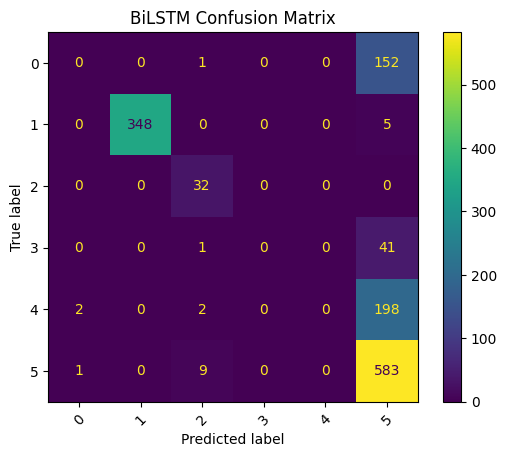

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For example, BiLSTM
y_true, y_pred_classes = evaluate_model("BiLSTM", bilstm, Xdl_val, ydl_val)
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("BiLSTM Confusion Matrix")
plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


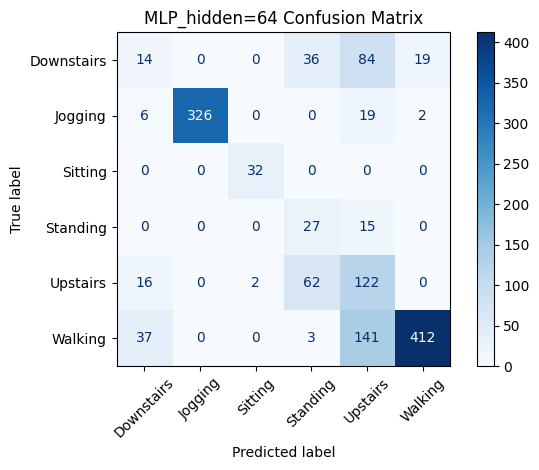

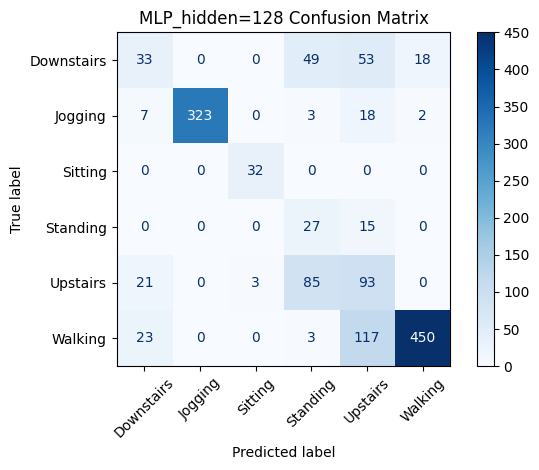

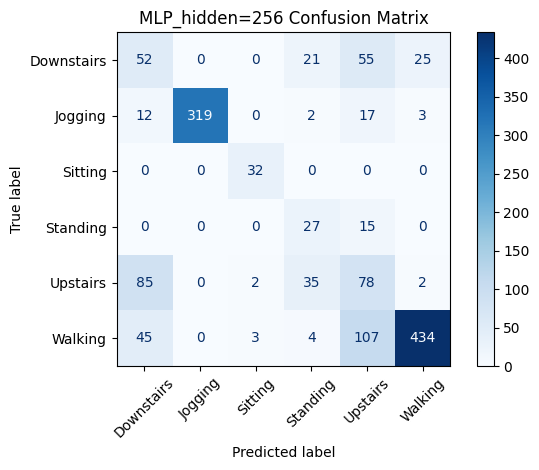

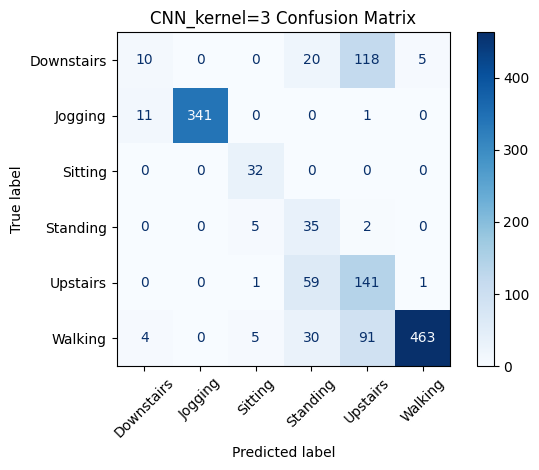

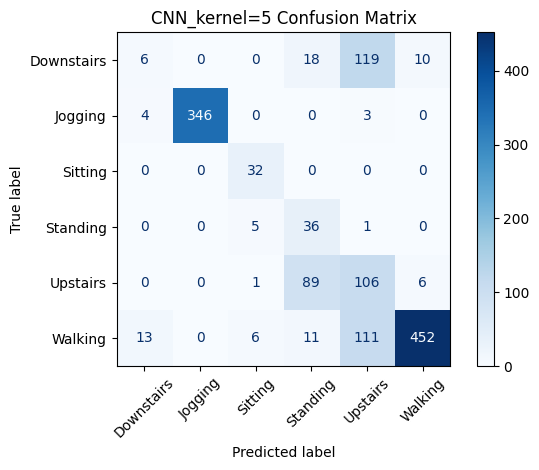

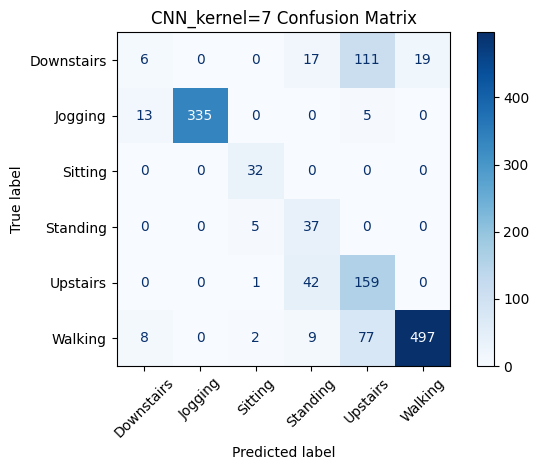

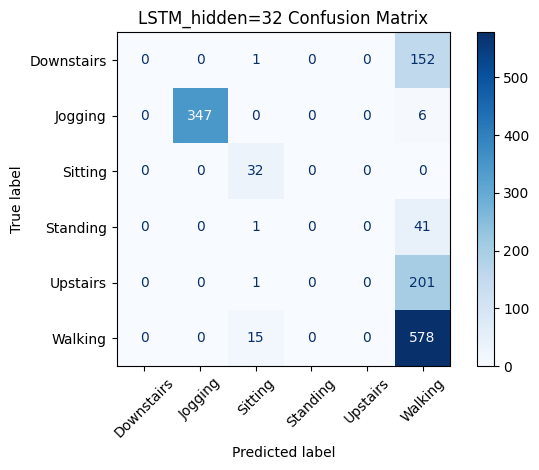

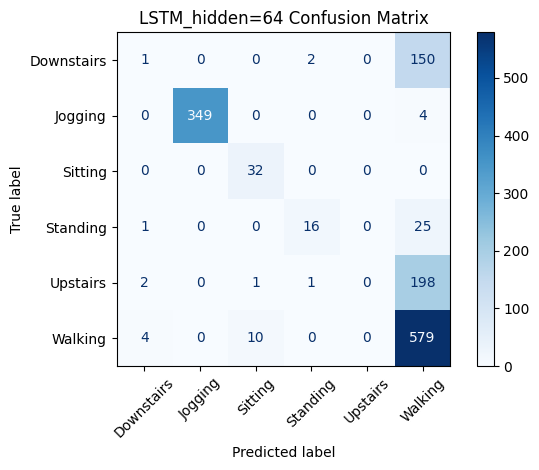

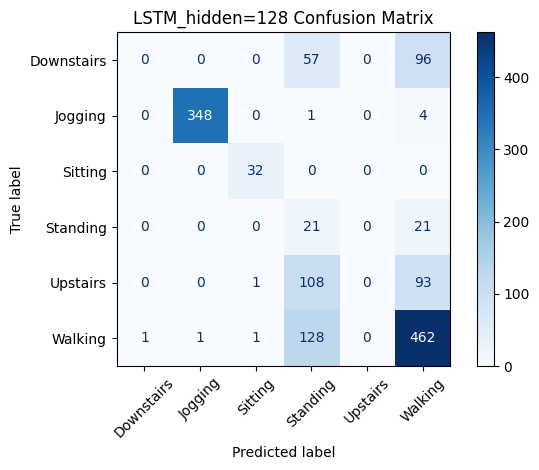

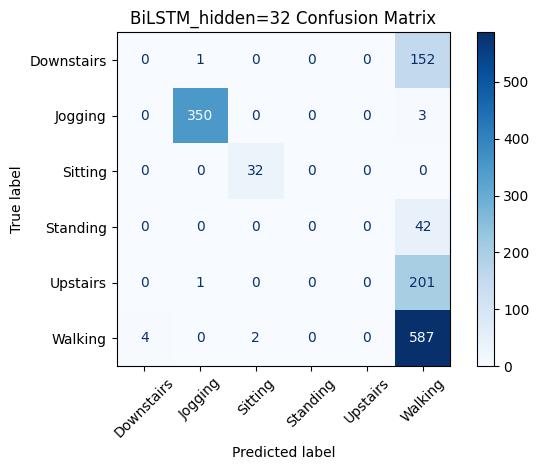

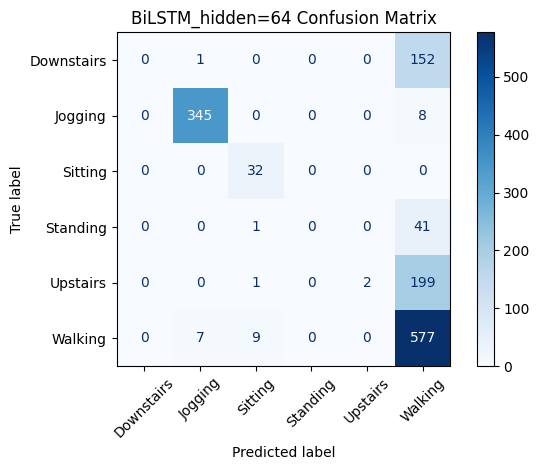

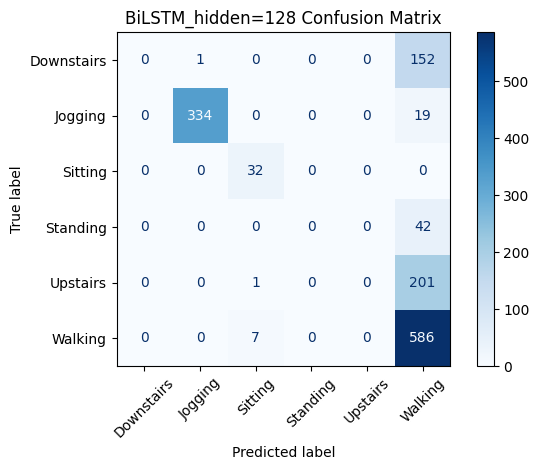

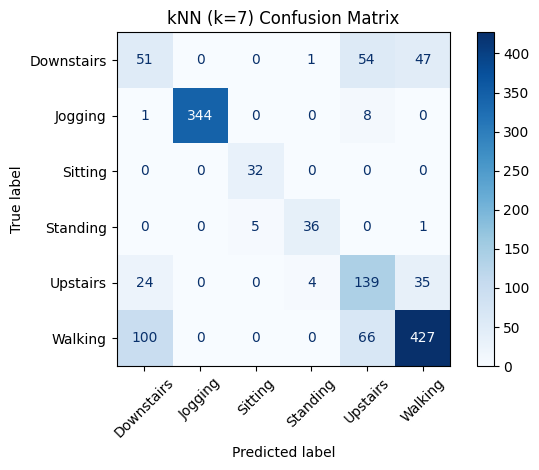

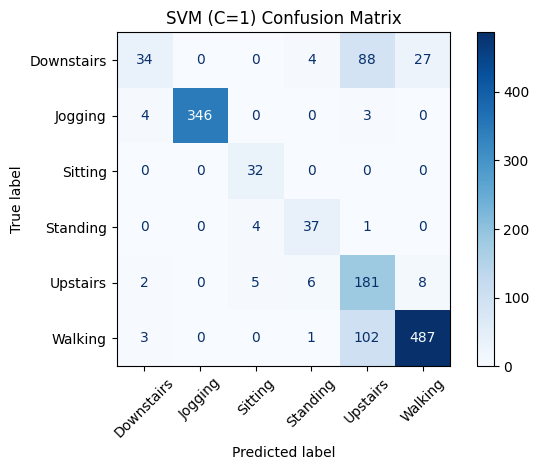

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Assumes original df is available and has all activity labels
label_encoder = LabelEncoder()
label_encoder.fit(df['activity'])
class_names = label_encoder.classes_

# Helper to evaluate Keras models
def eval_dl_model(name, model, X_val, y_val, reshape=False):
    X_val = X_val.reshape(len(X_val), -1) if reshape else X_val
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return name, y_true, y_pred_labels

# Define and evaluate DL hyperparameter sweep models (1 instance each)
dl_conf_models = []

# MLP variants
for h in [64, 128, 256]:
    name = f"MLP_hidden={h}"
    model = build_mlp(hidden=h, lr=0.005, layers=2)
    model.fit(Xdl_train.reshape(len(Xdl_train), -1), ydl_train, epochs=10, verbose=0)
    dl_conf_models.append(eval_dl_model(name, model, Xdl_val, ydl_val, reshape=True))

# CNN variants
for k in [3, 5, 7]:
    name = f"CNN_kernel={k}"
    model = build_cnn(kernel_size=k, dropout_rate=0.4)
    model.fit(Xdl_train, ydl_train, epochs=10, verbose=0)
    dl_conf_models.append(eval_dl_model(name, model, Xdl_val, ydl_val))

# LSTM variants
for h in [32, 64, 128]:
    name = f"LSTM_hidden={h}"
    model = build_lstm(hidden=h, bidirectional=False, dropout=0.3)
    model.fit(Xdl_train, ydl_train, epochs=10, verbose=0)
    dl_conf_models.append(eval_dl_model(name, model, Xdl_val, ydl_val))

# BiLSTM variants
for h in [32, 64, 128]:
    name = f"BiLSTM_hidden={h}"
    model = build_lstm(hidden=h, bidirectional=True, dropout=0.3)
    model.fit(Xdl_train, ydl_train, epochs=10, verbose=0)
    dl_conf_models.append(eval_dl_model(name, model, Xdl_val, ydl_val))

# Add classical models (best SVM and kNN)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

best_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7, metric='euclidean'))
])
best_knn.fit(Xf_train, y_train)
dl_conf_models.append(("kNN (k=7)", y_val, best_knn.predict(Xf_val)))

best_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, gamma='scale'))
])
best_svm.fit(Xf_train, y_train)
dl_conf_models.append(("SVM (C=1)", y_val, best_svm.predict(Xf_val)))

# Plot all confusion matrices
for name, y_true, y_pred in dl_conf_models:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()


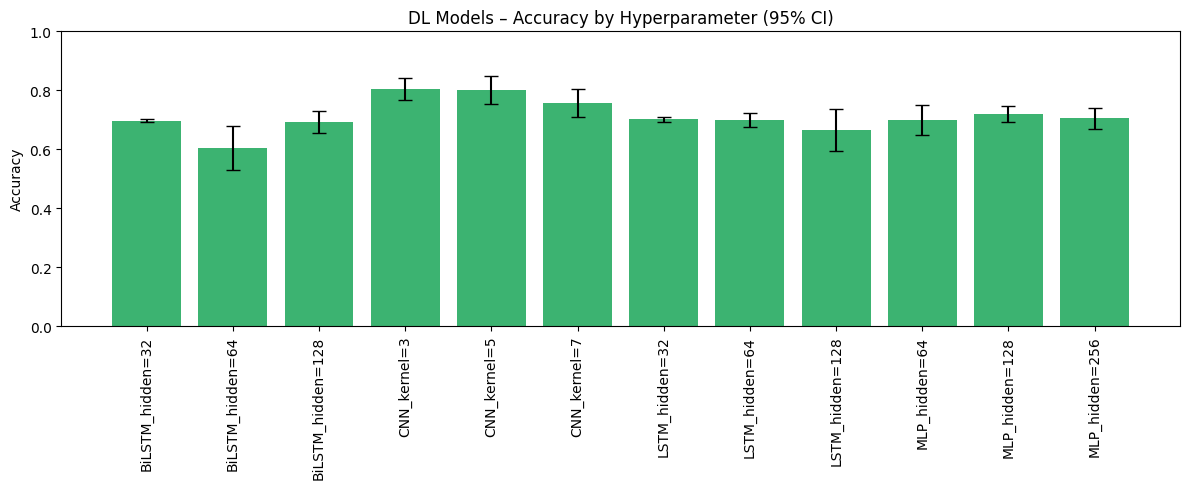

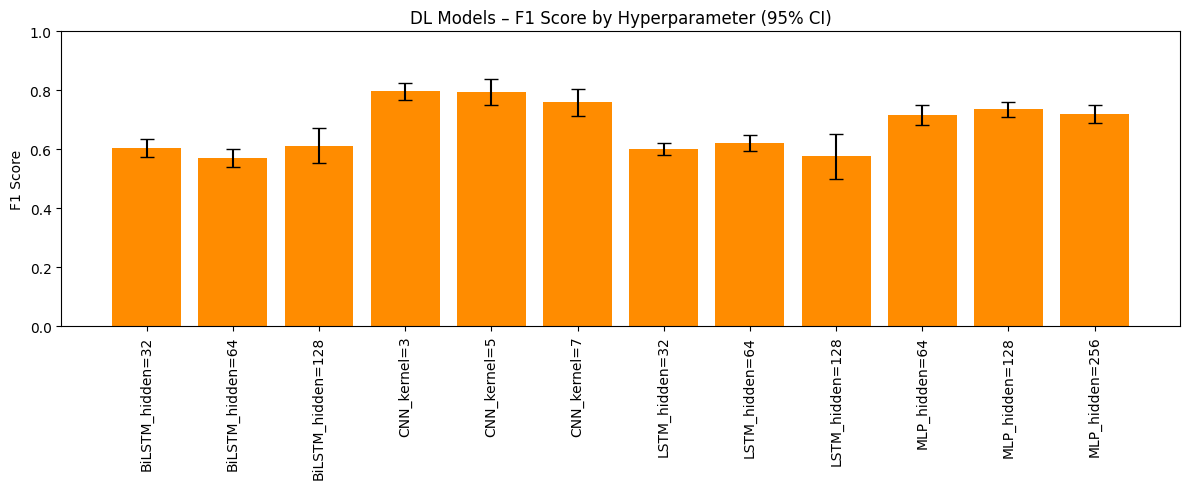

In [ ]:
# Add parameter sweep results for deep learning models
dl_param_sweep_results = {
    "MLP_hidden=64": {"accuracy": 0.699, "acc_ci": (0.649, 0.749), "f1": 0.717, "f1_ci": (0.683, 0.750)},
    "MLP_hidden=128": {"accuracy": 0.720, "acc_ci": (0.694, 0.745), "f1": 0.735, "f1_ci": (0.709, 0.761)},
    "MLP_hidden=256": {"accuracy": 0.705, "acc_ci": (0.669, 0.741), "f1": 0.720, "f1_ci": (0.690, 0.751)},
    "CNN_kernel=3": {"accuracy": 0.804, "acc_ci": (0.768, 0.841), "f1": 0.796, "f1_ci": (0.768, 0.824)},
    "CNN_kernel=5": {"accuracy": 0.801, "acc_ci": (0.753, 0.849), "f1": 0.794, "f1_ci": (0.750, 0.837)},
    "CNN_kernel=7": {"accuracy": 0.757, "acc_ci": (0.708, 0.806), "f1": 0.759, "f1_ci": (0.713, 0.806)},
    "LSTM_hidden=32": {"accuracy": 0.702, "acc_ci": (0.694, 0.710), "f1": 0.601, "f1_ci": (0.582, 0.619)},
    "LSTM_hidden=64": {"accuracy": 0.699, "acc_ci": (0.676, 0.721), "f1": 0.621, "f1_ci": (0.595, 0.647)},
    "LSTM_hidden=128": {"accuracy": 0.666, "acc_ci": (0.595, 0.737), "f1": 0.576, "f1_ci": (0.500, 0.652)},
    "BiLSTM_hidden=32": {"accuracy": 0.697, "acc_ci": (0.692, 0.703), "f1": 0.605, "f1_ci": (0.575, 0.636)},
    "BiLSTM_hidden=64": {"accuracy": 0.605, "acc_ci": (0.531, 0.679), "f1": 0.571, "f1_ci": (0.540, 0.602)},
    "BiLSTM_hidden=128": {"accuracy": 0.693, "acc_ci": (0.656, 0.729), "f1": 0.612, "f1_ci": (0.552, 0.672)},
}

# Sort results by model type for grouped plotting
sorted_keys = sorted(dl_param_sweep_results.keys(), key=lambda x: (x.split('_')[0], int(x.split('=')[1])))

acc_means = [dl_param_sweep_results[k]["accuracy"] for k in sorted_keys]
f1_means = [dl_param_sweep_results[k]["f1"] for k in sorted_keys]
acc_errs = [dl_param_sweep_results[k]["accuracy"] - dl_param_sweep_results[k]["acc_ci"][0] for k in sorted_keys]
f1_errs = [dl_param_sweep_results[k]["f1"] - dl_param_sweep_results[k]["f1_ci"][0] for k in sorted_keys]

x = np.arange(len(sorted_keys))

# Accuracy bar plot
plt.figure(figsize=(12, 5))
plt.bar(x, acc_means, yerr=acc_errs, capsize=5, color='mediumseagreen')
plt.xticks(x, sorted_keys, rotation=90)
plt.ylabel("Accuracy")
plt.title("DL Models – Accuracy by Hyperparameter (95% CI)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# F1-score bar plot
plt.figure(figsize=(12, 5))
plt.bar(x, f1_means, yerr=f1_errs, capsize=5, color='darkorange')
plt.xticks(x, sorted_keys, rotation=90)
plt.ylabel("F1 Score")
plt.title("DL Models – F1 Score by Hyperparameter (95% CI)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


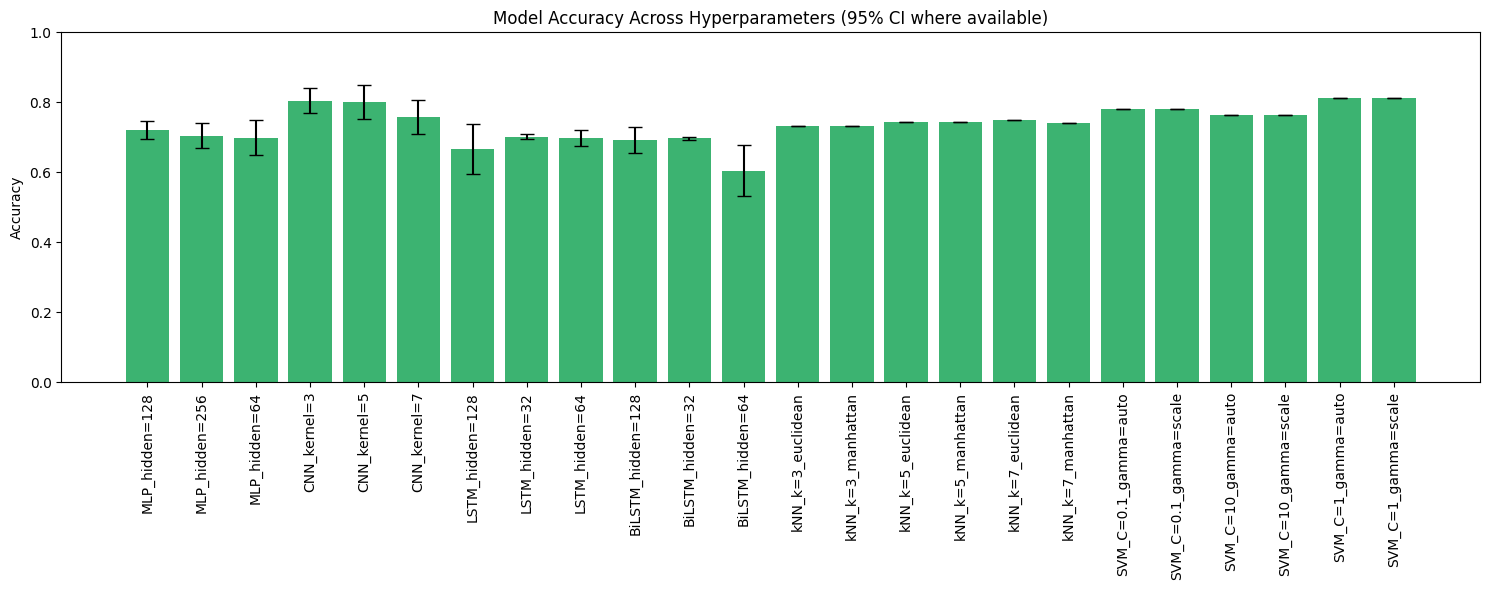

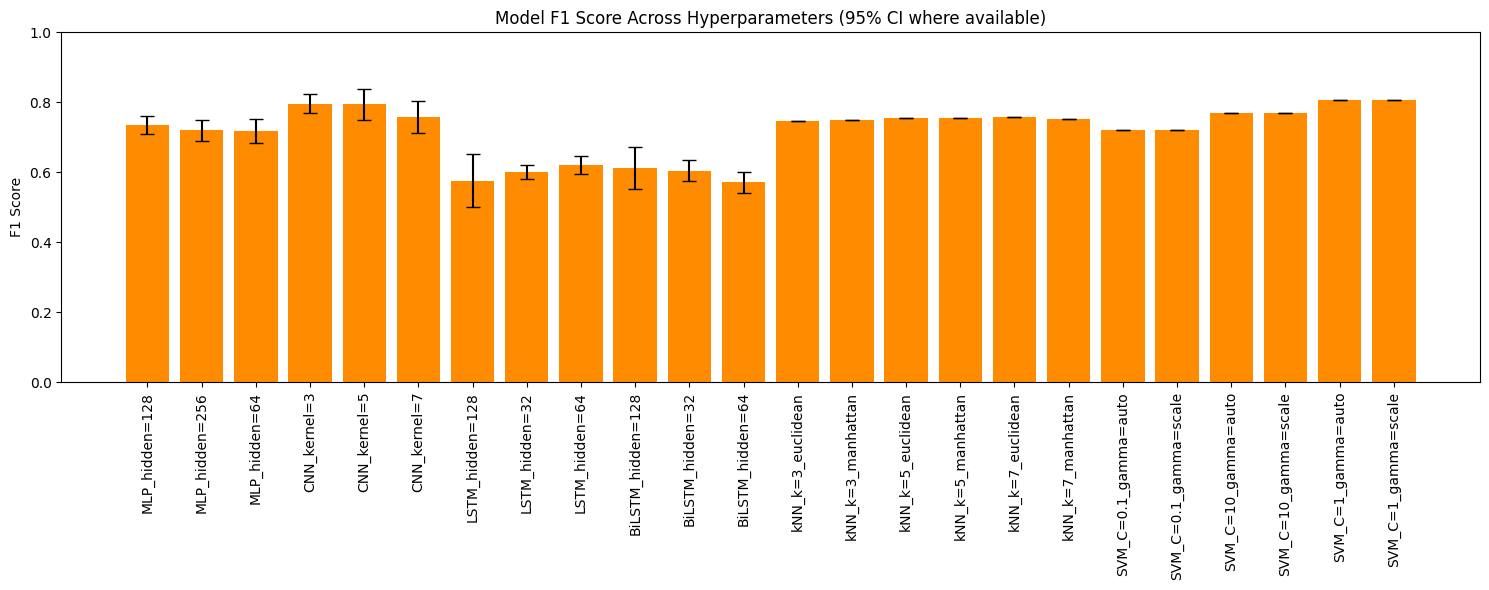

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Combine DL + SVM + kNN results
all_param_sweep_results = {
    # DL models
    "MLP_hidden=64": {"accuracy": 0.699, "acc_ci": (0.649, 0.749), "f1": 0.717, "f1_ci": (0.683, 0.750)},
    "MLP_hidden=128": {"accuracy": 0.720, "acc_ci": (0.694, 0.745), "f1": 0.735, "f1_ci": (0.709, 0.761)},
    "MLP_hidden=256": {"accuracy": 0.705, "acc_ci": (0.669, 0.741), "f1": 0.720, "f1_ci": (0.690, 0.751)},
    "CNN_kernel=3": {"accuracy": 0.804, "acc_ci": (0.768, 0.841), "f1": 0.796, "f1_ci": (0.768, 0.824)},
    "CNN_kernel=5": {"accuracy": 0.801, "acc_ci": (0.753, 0.849), "f1": 0.794, "f1_ci": (0.750, 0.837)},
    "CNN_kernel=7": {"accuracy": 0.757, "acc_ci": (0.708, 0.806), "f1": 0.759, "f1_ci": (0.713, 0.806)},
    "LSTM_hidden=32": {"accuracy": 0.702, "acc_ci": (0.694, 0.710), "f1": 0.601, "f1_ci": (0.582, 0.619)},
    "LSTM_hidden=64": {"accuracy": 0.699, "acc_ci": (0.676, 0.721), "f1": 0.621, "f1_ci": (0.595, 0.647)},
    "LSTM_hidden=128": {"accuracy": 0.666, "acc_ci": (0.595, 0.737), "f1": 0.576, "f1_ci": (0.500, 0.652)},
    "BiLSTM_hidden=32": {"accuracy": 0.697, "acc_ci": (0.692, 0.703), "f1": 0.605, "f1_ci": (0.575, 0.636)},
    "BiLSTM_hidden=64": {"accuracy": 0.605, "acc_ci": (0.531, 0.679), "f1": 0.571, "f1_ci": (0.540, 0.602)},
    "BiLSTM_hidden=128": {"accuracy": 0.693, "acc_ci": (0.656, 0.729), "f1": 0.612, "f1_ci": (0.552, 0.672)},

    # kNN models (no CI)
    "kNN_k=3_euclidean": {"accuracy": 0.732, "f1": 0.747},
    "kNN_k=3_manhattan": {"accuracy": 0.732, "f1": 0.748},
    "kNN_k=5_euclidean": {"accuracy": 0.745, "f1": 0.756},
    "kNN_k=5_manhattan": {"accuracy": 0.743, "f1": 0.754},
    "kNN_k=7_euclidean": {"accuracy": 0.748, "f1": 0.757},
    "kNN_k=7_manhattan": {"accuracy": 0.741, "f1": 0.751},

    # SVM models (no CI)
    "SVM_C=0.1_gamma=scale": {"accuracy": 0.780, "f1": 0.720},
    "SVM_C=0.1_gamma=auto": {"accuracy": 0.780, "f1": 0.720},
    "SVM_C=1_gamma=scale": {"accuracy": 0.812, "f1": 0.807},
    "SVM_C=1_gamma=auto": {"accuracy": 0.812, "f1": 0.807},
    "SVM_C=10_gamma=scale": {"accuracy": 0.765, "f1": 0.769},
    "SVM_C=10_gamma=auto": {"accuracy": 0.765, "f1": 0.769},
}

# Sort keys logically by model type and parameter
def sort_key(k):
    prefix_order = {"MLP": 0, "CNN": 1, "LSTM": 2, "BiLSTM": 3, "kNN": 4, "SVM": 5}
    prefix = k.split('_')[0]
    return (prefix_order.get(prefix, 99), k)

sorted_keys = sorted(all_param_sweep_results.keys(), key=sort_key)

# Prepare plotting values
acc_means = [all_param_sweep_results[k]["accuracy"] for k in sorted_keys]
f1_means = [all_param_sweep_results[k]["f1"] for k in sorted_keys]
acc_errs = [
    all_param_sweep_results[k]["accuracy"] - all_param_sweep_results[k].get("acc_ci", (all_param_sweep_results[k]["accuracy"],))[0]
    for k in sorted_keys
]
f1_errs = [
    all_param_sweep_results[k]["f1"] - all_param_sweep_results[k].get("f1_ci", (all_param_sweep_results[k]["f1"],))[0]
    for k in sorted_keys
]

x = np.arange(len(sorted_keys))

# Accuracy plot
plt.figure(figsize=(15, 6))
plt.bar(x, acc_means, yerr=acc_errs, capsize=5, color='mediumseagreen')
plt.xticks(x, sorted_keys, rotation=90)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Across Hyperparameters (95% CI where available)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# F1-score plot
plt.figure(figsize=(15, 6))
plt.bar(x, f1_means, yerr=f1_errs, capsize=5, color='darkorange')
plt.xticks(x, sorted_keys, rotation=90)
plt.ylabel("F1 Score")
plt.title("Model F1 Score Across Hyperparameters (95% CI where available)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
